# Assessment of nephrotoxicity of vancomycin

The aim of this study was to quantify the association between nephrotoxicity and vancomycin in a large, multi-center US database.
The study matches patients who were admitted to the emergency department and received vancomycin on ICU admission versus those who did not receive vancomycin on admission. The matching is done using a propensity score built using the following covariates:

* presence of sepsis or septic shock
  * SIRS, lactate, elevated WBC, hypotension, fever
* soft tissue infection/skin infections (?cellulitis, or APACHE admission diagnosis Sepsis:skin)
* risk factors for community acquired MRSA
* risk factors for MDR in general (hospitalization for more than 48 hours in the last 90 days, residence in a nursing home or extended care facility, home infusion therapy, chronic dialysis within one month, home wound care)
* known colonization with MRSA
* immunocompromized state even in the absence of shock (probably captured through the comorbidity fields)

## Definitions

* **drug on admission:** patient received medication order -12 to 12 hours upon admission to the ICU
* **baseline creatinine:** first creatinine value between -12 to 12 hours upon admission to the ICU
* **AKI:** following KDIGO guidelines using only creatinine, any instance of AKI between 2-7 days after their ICU admission.

KDIGO guidelines for AKI are: >= 50% change from baseline over 7 days, or absolute increase of 0.3 in creatinine over 48 hours.

## 0. Setup

In [2]:
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import psycopg2
import pymatch
from pymatch.Matcher import Matcher

%matplotlib inline

# helper functions stored in local py file
import utils

# Helper function to read data from database
conn_info = "host='localhost' dbname='eicu' user='alistairewj' port=5647"
con = psycopg2.connect(conn_info)

def run_query(query, con=con):
    return pd.read_sql_query(query, con)

# 1. Summarize cohort

In [3]:
co = run_query("select * from vanco.cohort")

In [4]:
print('== EXCLUSIONS - TOTAL ==')
N = co.shape[0]
print(f'{N:6d} unique unit stays.')
for c in co.columns:
    if c.startswith('exclude_'):
        N = co[c].sum()
        mu = co[c].mean()*100.0
        print(f'  {N:6d} ({mu:4.1f}%) - {c}')
        
print('\n== EXCLUSIONS - SEQUENTIAL ==')
N = co.shape[0]
print(f'{N:7d} unique unit stays.')
idx = co['patientunitstayid'].notnull()
for c in co.columns:
    if c.startswith('exclude_'):
        # index patients removed by this exclusion
        idxRem = (co[c]==1)
        # calculate number of patients being removed, after applying prev excl
        N = (idx & idxRem).sum()
        mu = N/co.shape[0]*100.0
        idx = idx & (~idxRem)
        n_rem = idx.sum()
        
        print(f'- {N:5d} = {n_rem:6d} ({mu:4.1f}% removed) - {c}')

== EXCLUSIONS - TOTAL ==
3336449 unique unit stays.
   15630 ( 0.5%) - exclude_before_2005
  456518 (13.7%) - exclude_sdu
  124485 ( 3.7%) - exclude_short_stay
  1990155 (59.6%) - exclude_non_ed_admit
  296774 ( 8.9%) - exclude_secondary_stay
  514249 (15.4%) - exclude_no_med_interface
  121025 ( 3.6%) - exclude_dialysis_chronic
  324262 ( 9.7%) - exclude_dialysis_first_week
  548095 (16.4%) - exclude_cr_missing_baseline
  1281815 (38.4%) - exclude_cr_missing_followup

== EXCLUSIONS - SEQUENTIAL ==
3336449 unique unit stays.
- 15630 = 3320819 ( 0.5% removed) - exclude_before_2005
- 456328 = 2864491 (13.7% removed) - exclude_sdu
- 85391 = 2779100 ( 2.6% removed) - exclude_short_stay
- 1531330 = 1247770 (45.9% removed) - exclude_non_ed_admit
- 270504 = 977266 ( 8.1% removed) - exclude_secondary_stay
- 166876 = 810390 ( 5.0% removed) - exclude_no_med_interface
- 26287 = 784103 ( 0.8% removed) - exclude_dialysis_chronic
- 54367 = 729736 ( 1.6% removed) - exclude_dialysis_first_week
- 37592

# 3. Analysis


## Get data from database

In [5]:
# covariates from APACHE table
dem = run_query("SELECT dem.* FROM vanco.demographics dem")

# vancomycin drug doses
v = run_query("SELECT v.* FROM vanco.vanco v")

# AKI
query = """
SELECT 
  patientunitstayid
  , chartoffset
  , creatinine, creatinine_reference, creatinine_baseline
  , aki_48h, aki_7d
FROM vanco.aki
"""
aki = run_query(query)

In [6]:
# APACHE
query = """
SELECT 
  patientunitstayid
  , apache_prob
  , immunocompromised
FROM vanco.apache
"""
apache = run_query(query)

# convert apache predictions into numeric
apache['apache_prob'] = pd.to_numeric(apache['apache_prob'])

# sepsis/infection/organ failure
query = """
SELECT 
  patientunitstayid
  , sepsis as sepsis_explicit
  , infection
  , organfailure
  , infection_skin_soft_tissue
FROM vanco.sepsis_infection
"""
dx = run_query(query)

## Collapse vancomycin data

The `v` dataframe has every vancomycin administration for a patient.

Here we collapse it into two binary columns:

* 'vanco_adm' - vancomycin was administered on ICU admission (between hours -12 and 12)
* 'vanco_wk' - vancomycin was administered sometime between 2-7 days after ICU admission

In [7]:
v_df = utils.extract_adm_and_wk(v, 'vanco')

Print out the proportion of patients with/without vancomycin after exclusions.

In [8]:
# get patient unit stay ID after applying exclusions
idxKeep = co['patientunitstayid'].notnull()
for c in co.columns:
    if c.startswith('exclude_'):
        idxKeep = idxKeep & (co[c]==0)
        
ptid = co.loc[idxKeep, 'patientunitstayid'].values
n_pt = len(ptid)
# limit to those in vancomycin dataframe
ptid = [x for x in ptid if x in v_df.index]

N = len(ptid)
print(f'{n_pt} stays after exclusions.')
for c in v_df.columns:
    N = v_df.loc[ptid, c].sum()
    mu = N / n_pt * 100.0
    print(f'  {N} ({mu:3.1f}%) with {c}')
    
# if they have both adm, then row-wise sum must be greater than 1
N = (v_df.loc[ptid, :] == 1).sum(axis=1)
N = (N>1).sum()
mu = N / n_pt * 100.0
print(f'  {N} ({mu:3.1f}%) with both')

394373 stays after exclusions.
  59935 (15.2%) with vanco_adm
  56968 (14.4%) with vanco_wk
  31769 (8.1%) with both


## Create a dataframe for analysis

The below code block:

* Applies exclusions
* Adds vancomycin binary flags
* Adds AKI flag

In [9]:
# drop exclusions
idxKeep = co['patientunitstayid'].notnull()
for c in co.columns:
    if c.startswith('exclude_'):
        idxKeep = idxKeep & (co[c]==0)

# combine data into single dataframe
df = co.loc[idxKeep, ['patientunitstayid']].merge(dem, how='inner', on='patientunitstayid')

# add vanco administration
df = df.merge(v_df, how='left', on='patientunitstayid')

# if ptid missing in vanco dataframe, then no vanco was received
# therefore impute 0
for c in v_df.columns:
    df[c].fillna(0, inplace=True)
    df[c] = df[c].astype(int)

aki_grp = aki.groupby('patientunitstayid')[['creatinine', 'aki_48h', 'aki_7d']].max()
aki_grp.reset_index(inplace=True)
df = df.merge(aki_grp, how='inner', on='patientunitstayid')

df['aki'] = ((df['aki_48h'] == 1) | (df['aki_7d'] == 1)).astype(int)

# add in apache/diagnosis data
df = df.merge(apache, how='left', on='patientunitstayid')
for c in apache.columns:
    if c != 'apache_prob':
        df[c].fillna(0, inplace=True)
        df[c] = df[c].astype(int)
df = df.merge(dx, how='left', on='patientunitstayid')
for c in dx.columns:
    df[c].fillna(0, inplace=True)
    df[c] = df[c].astype(int)

df['sepsis'] = (df['sepsis_explicit'] == 1) | ((df['infection'] == 1) & (df['organfailure'] == 1))
df['sepsis'] = df['sepsis'].astype(int)

# convert binary vars to string so they are interpreted as categorical
for c in ['immunocompromised', 'sepsis', 'infection_skin_soft_tissue']:
    df[c] = df[c].map({0: 'no', 1: 'yes'})

# avoid conflicts in column names with pymatch
df.rename(columns={'weight': 'weight_kg', 'height': 'height_cm'}, inplace=True)

# ensure apache/age are continuous
idx = df['age'] == '> 89'
df.loc[idx, 'age'] = 90

idx = df['age'] == ''
df.loc[idx, 'age'] = np.nan
df['age'] = pd.to_numeric(df['age'], errors='coerce')

idx = df['apachescore'] == -1
df.loc[idx, 'apachescore'] = np.nan
df['apachescore'] = df['apachescore'].astype(float)

idx = df['apache_group'] == '-1'
df.loc[idx, 'apache_group'] = 'missing'

# set patientunitstayid as index
df.set_index('patientunitstayid', inplace=True)
df.sort_index(inplace=True)
print(df.shape)
df.head()

(394373, 22)


,unitdischargeoffset,age,gender,weight_kg,height_cm,bmi,bmi_group,apachescore,apache_group,vanco_adm,...,aki_48h,aki_7d,aki,apache_prob,immunocompromised,sepsis_explicit,infection,organfailure,infection_skin_soft_tissue,sepsis
patientunitstayid,,,,,,,,,,,,,,,,,,,,,
9,2199,54.0,Female,91.30,170.2,32.0,overweight,47.0,41-50,1,...,0,0,0,0.053958,no,0,0,1,no,no
13,2486,73.0,Male,95.20,182.8,28.0,overweight,44.0,41-50,0,...,0,0,0,0.043376,no,0,0,0,no,no
15,27068,22.0,Male,77.12,177.8,24.0,normal,98.0,91-100,0,...,0,1,1,0.465333,no,1,1,1,no,yes
17,2071,42.0,Male,122.70,195.5,32.0,overweight,27.0,21-30,0,...,0,0,0,0.007900,no,0,0,0,no,no
20,2943,37.0,Female,91.28,157.5,37.0,overweight,46.0,41-50,1,...,0,0,0,0.013209,no,0,0,0,no,no


## Propensity matching

In [10]:
# pymatch complains a lot!
warnings.filterwarnings('ignore')

In [11]:
# Vanco + No Vanco Analysis
print('\n=== Cross-tabulation of vanco on admission vs. vanco during the week (days 2-7) ===')
display(pd.crosstab(df['vanco_adm'], df['vanco_wk'], margins=True))
print('Normalized:')
display(pd.crosstab(df['vanco_adm'], df['vanco_wk'], margins=True, normalize=True))


=== Cross-tabulation of vanco on admission vs. vanco during the week (days 2-7) ===


vanco_wk,0,1,All
vanco_adm,,,
0,309239,25199,334438
1,28166,31769,59935
All,337405,56968,394373


Normalized:


vanco_wk,0,1,All
vanco_adm,,,
0,0.784128,0.063896,0.848025
1,0.071420,0.080556,0.151975
All,0.855548,0.144452,1.000000


Our first (preliminary) propensity score will use only APACHE-IV as the covariate.

In [12]:
# INITIAL VANCO vs. NO VANCO
test = df[(df['vanco_adm'] == 1)].copy()
control = df[(df['vanco_wk'] == 0) & (df['vanco_adm'] == 0)].copy()
test['vanco_status'] = 1
control['vanco_status'] = 0

# vars we retain:
cols = ['vanco_status', 'age', 'apache_prob', 'sepsis', 'infection_skin_soft_tissue', 'immunocompromised']
cols_exclude = [c for c in test.columns if c not in cols]

print('Dataframe being used:')
display(test[cols].head())

m = Matcher(test, control, yvar="vanco_status", exclude=cols_exclude)

Dataframe being used:


,vanco_status,age,apache_prob,sepsis,infection_skin_soft_tissue,immunocompromised
patientunitstayid,,,,,,
9,1,54.0,0.053958,no,no,no
20,1,37.0,0.013209,no,no,no
143,1,85.0,0.227421,yes,no,no
214,1,63.0,0.019505,no,no,no
224,1,79.0,0.033398,yes,no,no


Formula:
vanco_status ~ age+apache_prob+immunocompromised+infection_skin_soft_tissue+sepsis
n majority: 213360
n minority: 46929


In [13]:
np.random.seed(94020)
# predict the y outcome balancing the classes
# repeat 100 times to be sure we use a lot of majority class data
m.fit_scores(balance=True, nmodels=10)

Fitting Models on Balanced Samples: 10\10
Average Accuracy: 74.03%


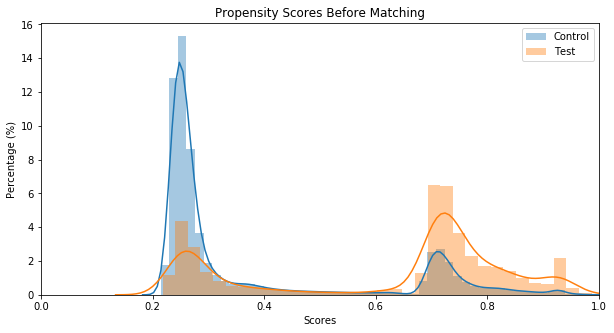

In [14]:
m.predict_scores()
m.plot_scores()

Determine the best caliper for matching scores.

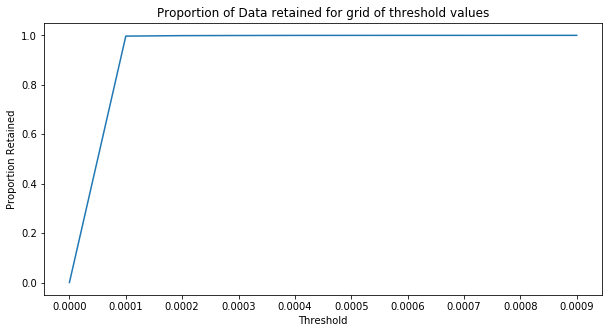

In [15]:
m.tune_threshold(method='random')

The above tells us that a calpier of 0.0005 will allow ~100% of data to be matched.

Next we allow for sampling with replacement using the above threshold of 0.0005.

In [16]:
m.match(method="min", nmatches=1, threshold=0.0005)
m.record_frequency()

,freq,n_records
0,1,71646
1,2,5878
2,3,1878
3,4,647
4,5,246
5,6,86
6,7,38
7,8,17
8,9,7
9,10,1


Generate a weight vector accounting for sampling with replacement.

In [17]:
m.assign_weight_vector()

`m` has also assigned a match_id to each record indicating paired matches (since we use nmatches=1). We can verify that matched records have scores within 0.0005 of each other.



In [18]:
m.matched_data.sort_values("match_id").head(n=6)

,record_id,weight,unitdischargeoffset,age,gender,weight_kg,height_cm,bmi,bmi_group,apachescore,...,apache_prob,immunocompromised,sepsis_explicit,infection,organfailure,infection_skin_soft_tissue,sepsis,vanco_status,scores,match_id
0,0,1.00,2199,54.0,Female,91.30,170.20,32.0,overweight,47.0,...,0.053958,no,0,0,1,no,no,1,0.260589,0
93703,368010,1.00,2536,81.0,Female,81.60,172.70,27.0,overweight,57.0,...,0.117094,no,0,0,0,no,no,0,0.260588,0
1,1,1.00,2943,37.0,Female,91.28,157.50,37.0,overweight,46.0,...,0.013209,no,0,0,0,no,no,1,0.260203,1
59100,124640,1.00,1202,38.0,Female,183.10,172.72,61.0,overweight,18.0,...,0.015548,no,0,1,0,no,no,0,0.260203,1
56015,109066,0.25,11727,59.0,Female,57.00,152.40,25.0,overweight,59.0,...,0.166635,no,0,1,1,no,yes,0,0.757471,2
2,2,1.00,3980,85.0,Male,84.00,177.80,27.0,overweight,78.0,...,0.227421,no,1,1,1,no,yes,1,0.757466,2


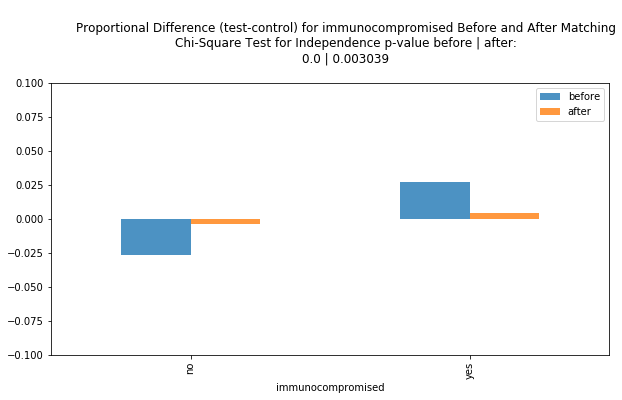

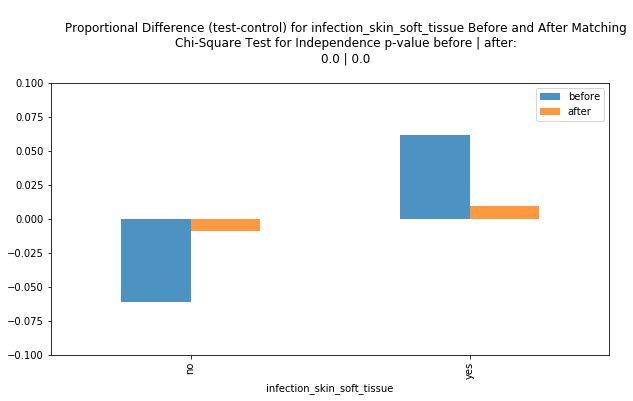

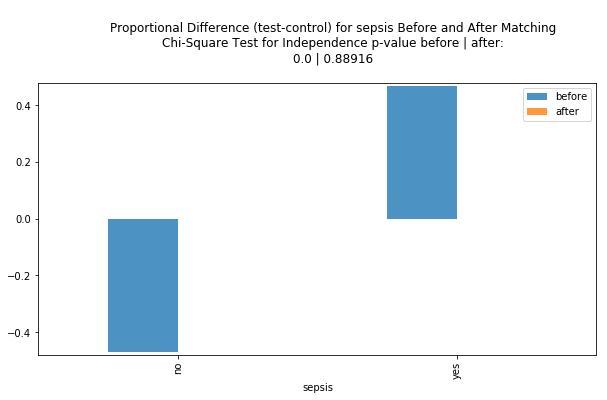

In [19]:
# no categorical variables -> this errors
categorical_results = m.compare_categorical(return_table=True)

,var,ks_before,ks_after,grouped_chisqr_before,grouped_chisqr_after,std_median_diff_before,std_median_diff_after,std_mean_diff_before,std_mean_diff_after
0,age,0.0,0.0,0.0,0.0,0.114223,0.000000,0.072659,0.013479
1,apache_prob,0.0,0.0,1.0,1.0,0.306257,-0.017509,0.395705,-0.040009


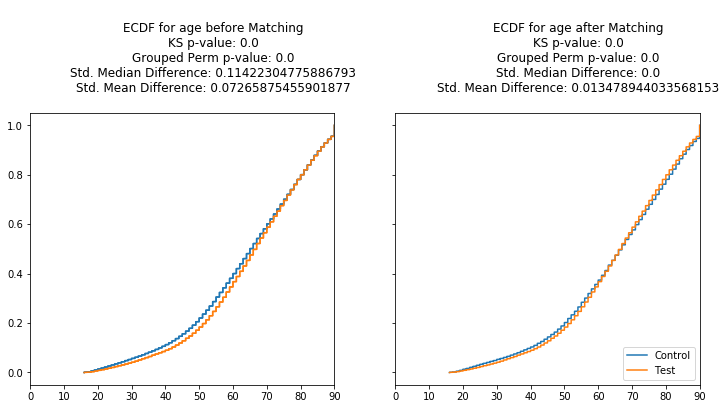

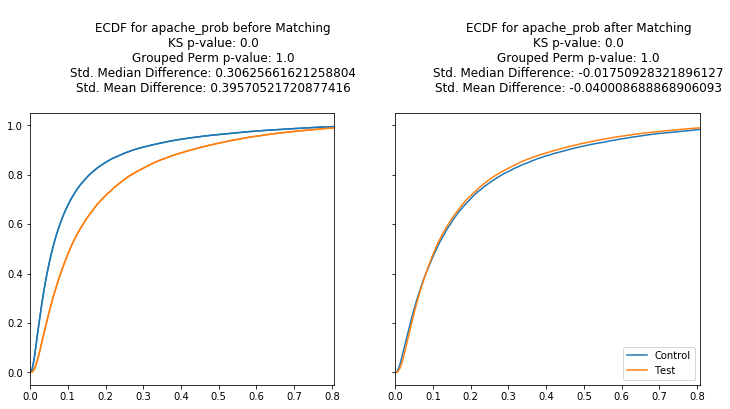

In [20]:
cc = m.compare_continuous(return_table=True)
display(cc)

In [21]:
# now grab the matched data into a single dataframe
m_control = m.matched_data.loc[m.matched_data['vanco_status']==0].copy()
m_exposure = m.matched_data.loc[m.matched_data['vanco_status']==1].copy()


df_matched = m_control.merge(m_exposure, how='left', on='match_id',
                             suffixes=('_control', '_exposure'))

print(df_matched.shape)

df_matched.head()

(46929, 53)


,record_id_control,weight_control,unitdischargeoffset_control,age_control,gender_control,weight_kg_control,height_cm_control,bmi_control,bmi_group_control,apachescore_control,...,aki_exposure,apache_prob_exposure,immunocompromised_exposure,sepsis_explicit_exposure,infection_exposure,organfailure_exposure,infection_skin_soft_tissue_exposure,sepsis_exposure,vanco_status_exposure,scores_exposure
0,59935,1.0,2486,73.0,Male,95.20,182.8,28.0,overweight,44.0,...,0,0.038699,no,0,0,1,no,no,1,0.239713
1,59936,1.0,27068,22.0,Male,77.12,177.8,24.0,normal,98.0,...,1,0.582228,no,1,1,1,no,yes,1,0.871963
2,59938,0.5,5784,69.0,Male,103.00,188.0,29.0,overweight,70.0,...,1,0.032867,no,1,1,1,no,yes,1,0.734881
3,59938,0.5,5784,69.0,Male,103.00,188.0,29.0,overweight,70.0,...,0,0.168475,no,1,1,1,no,yes,1,0.734883
4,59939,1.0,46591,74.0,Female,91.27,152.4,39.0,overweight,116.0,...,1,0.674079,no,0,1,1,no,yes,1,0.900580


In [22]:
# Calculate Odds Ratio
print('\n=== Odds ratio of exposure ===\n')
diseased_exposed = len(m_exposure[m_exposure['aki'] == 1])
healthy_exposed = len(m_exposure[m_exposure['aki'] == 0])
diseased_nonexposed = len(m_control[m_control['aki'] == 1])
healthy_nonexposed = len(m_control[m_control['aki'] == 0])

utils.get_odds_ratio(diseased_exposed, healthy_exposed, diseased_nonexposed, healthy_nonexposed)


=== Odds ratio of exposure ===

Diseased + Exposed: 16629
Healthy + Exposed: 30300
Diseased + Nonexposed: 16081
Healthy + Nonexposed: 30848
Odds Ratio: 1.0527796101542872
95% CI: (1.0248827718056155, 1.0814357876305754)


In [23]:
# Calculate Odds Ratio
print('\n=== Odds ratio of exposure ===\n')
diseased_exposed = len(m_exposure[m_exposure['aki'] == 1])
healthy_exposed = len(m_exposure[m_exposure['aki'] == 0])
diseased_nonexposed = len(m_control[m_control['aki'] == 1])
healthy_nonexposed = len(m_control[m_control['aki'] == 0])

utils.get_odds_ratio(diseased_exposed, healthy_exposed, diseased_nonexposed, healthy_nonexposed)


=== Odds ratio of exposure ===

Diseased + Exposed: 16629
Healthy + Exposed: 30300
Diseased + Nonexposed: 16081
Healthy + Nonexposed: 30848
Odds Ratio: 1.0527796101542872
95% CI: (1.0248827718056155, 1.0814357876305754)


# Define a function to do all the above

In [24]:
def calculate_or(exposure, control,
                 cols=['age', 'apache_prob', 'sepsis', 'infection_skin_soft_tissue', 'immunocompromised'],
                 outcome_var='aki',
                 seed=389202):

    np.random.seed(seed)
    # make sure we don't overwrite the legit column status
    if 'status' in exposure.columns:
        exposure['status_original'] = exposure['status']
        control['status_original'] = control['status']
    exposure['status'] = 1
    control['status'] = 0
  
    # vars we exclude
    cols_exclude = [c for c in exposure.columns if c not in cols and c != 'status']
        
    print('Dataframe being used:')
    display(exposure[cols].head())

    m = Matcher(exposure, control, yvar="status", exclude=cols_exclude)

    # predict the y outcome balancing the classes
    # repeat 100 times to be sure we use a lot of majority class data
    m.fit_scores(balance=True, nmodels=100)
  
    m.predict_scores()
    m.plot_scores()
  
    # m.tune_threshold(method='random')

    m.match(method="min", nmatches=1, threshold=0.0005)
    m.record_frequency()

    m.assign_weight_vector()

    m.matched_data.sort_values("match_id").head(n=6)

    # no categorical variables -> this errors
    categorical_results = m.compare_categorical(return_table=True)
    cc = m.compare_continuous(return_table=True)
    display(cc)

    # now grab the matched data into a single dataframe
    m_control = m.matched_data.loc[m.matched_data['status']==0].copy()
    m_exposure = m.matched_data.loc[m.matched_data['status']==1].copy()


    df_matched = m_control.merge(m_exposure, how='left', on='match_id',
                               suffixes=('_control', '_exposure'))

    print(df_matched.shape)

    # df_matched.head()

    # Calculate Odds Ratio
    print(f'\n=== Odds ratio of exposure against {outcome_var} ===\n')
    diseased_exposed = len(m_exposure[m_exposure[outcome_var] == 1])
    healthy_exposed = len(m_exposure[m_exposure[outcome_var] == 0])
    diseased_nonexposed = len(m_control[m_control[outcome_var] == 1])
    healthy_nonexposed = len(m_control[m_control[outcome_var] == 0])

    utils.get_odds_ratio(diseased_exposed, healthy_exposed, diseased_nonexposed, healthy_nonexposed)
  
    return m

### Primary analysis

* **exposure**: treated with vancomycin on admission to the ICU
* **control**: *not* treated with vancomycin, for the first 7 days of stay, starting at unit admit time
* **excluded**: patients treated with vanco later in the ICU stay, but not on admission

Dataframe being used:


,age,apache_prob,sepsis,infection_skin_soft_tissue,immunocompromised
patientunitstayid,,,,,
9,54.0,0.053958,no,no,no
20,37.0,0.013209,no,no,no
143,85.0,0.227421,yes,no,no
214,63.0,0.019505,no,no,no
224,79.0,0.033398,yes,no,no


Formula:
status ~ age+apache_prob+immunocompromised+infection_skin_soft_tissue+sepsis
n majority: 213360
n minority: 46929
Fitting Models on Balanced Samples: 100\100
Average Accuracy: 74.06%


,var,ks_before,ks_after,grouped_chisqr_before,grouped_chisqr_after,std_median_diff_before,std_median_diff_after,std_mean_diff_before,std_mean_diff_after
0,age,0.0,0.0,0.0,0.0,0.114223,0.000000,0.072659,0.006712
1,apache_prob,0.0,0.0,1.0,1.0,0.306257,-0.012932,0.395705,-0.040403


(46929, 53)

=== Odds ratio of exposure against aki ===

Diseased + Exposed: 16629
Healthy + Exposed: 30300
Diseased + Nonexposed: 15897
Healthy + Nonexposed: 31032
Odds Ratio: 1.0713172483506135
95% CI: (1.0428898711507404, 1.1005195067693176)


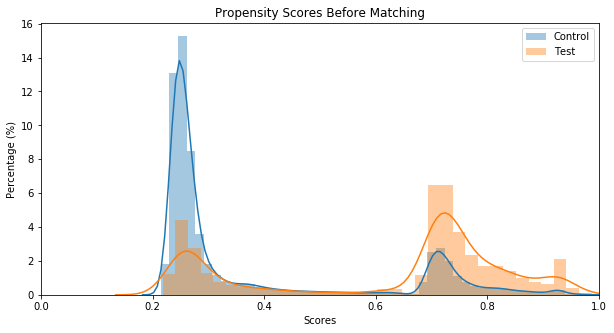

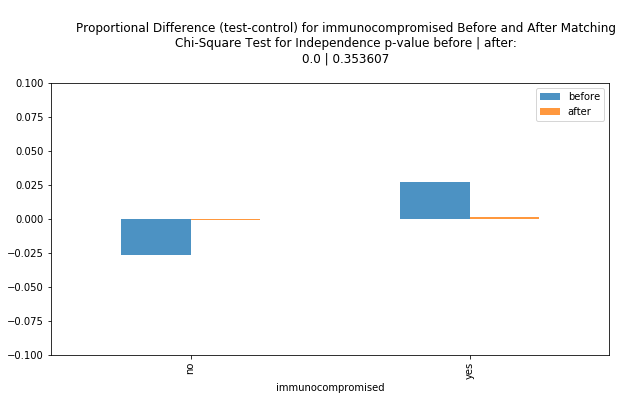

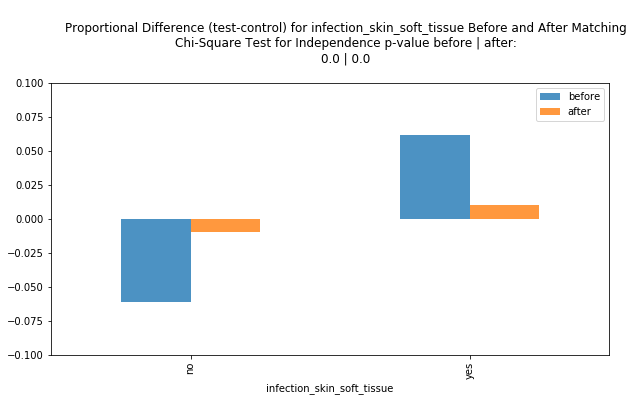

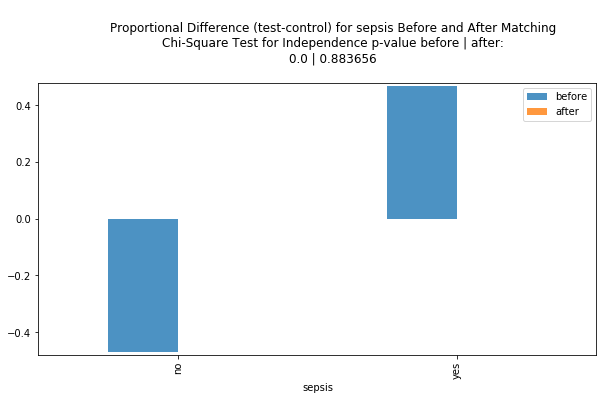

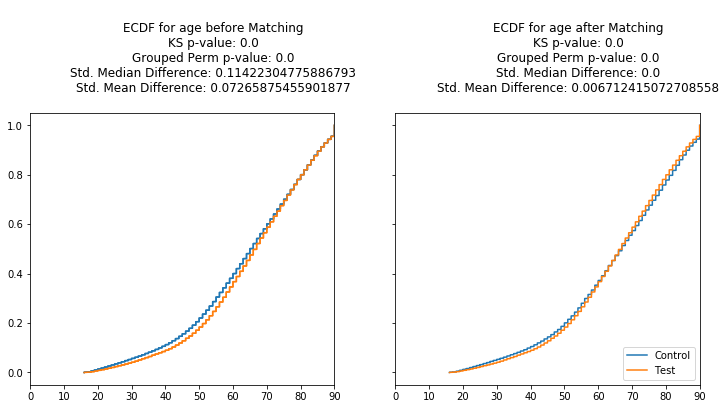

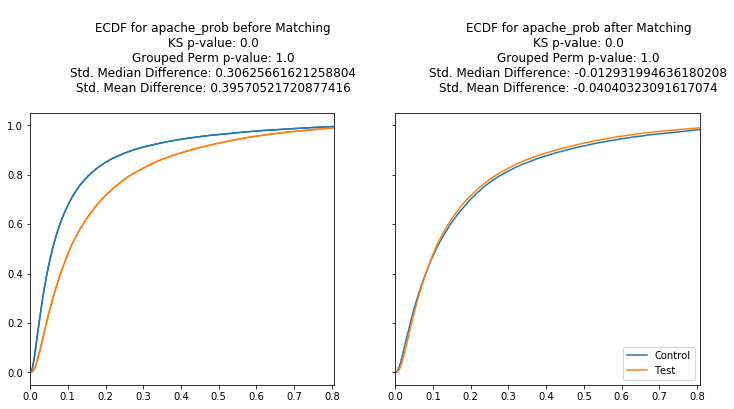

In [25]:
# INITIAL VANCO vs. NO VANCO
novanco = df[(df['vanco_wk'] == 0) & (df['vanco_adm'] == 0)]
vanco = df[(df['vanco_adm'] == 1)]
m_primary = calculate_or(exposure=vanco, control=novanco, seed=12938)

In [26]:
yr = run_query("""
select co.patientunitstayid, pt.hospitaldischargeyear from vanco.cohort co
INNER JOIN eicu_full_phi.patient pt
ON co.patientunitstayid = pt.patientunitstayid
WHERE exclude_before_2005 = 0
AND exclude_sdu = 0
AND exclude_short_stay = 0
AND exclude_non_ed_admit = 0
AND exclude_no_med_interface = 0
AND exclude_secondary_stay = 0
AND exclude_dialysis_chronic = 0
AND exclude_dialysis_first_week = 0
AND exclude_cr_missing_baseline = 0
AND exclude_cr_missing_followup = 0
""")

(309239, 22)
(59935, 22)
(309239, 24)
(59935, 24)
Dataframe being used:


,age,apache_prob,sepsis,infection_skin_soft_tissue,immunocompromised,hospitaldischargeyear
0,54.0,0.053958,no,no,no,2014
1,37.0,0.013209,no,no,no,2015
2,85.0,0.227421,yes,no,no,2011
3,63.0,0.019505,no,no,no,2014
4,79.0,0.033398,yes,no,no,2012


Formula:
status ~ age+apache_prob+immunocompromised+infection_skin_soft_tissue+sepsis+hospitaldischargeyear
n majority: 213360
n minority: 46929
Fitting Models on Balanced Samples: 100\100
Average Accuracy: 74.09%


,var,ks_before,ks_after,grouped_chisqr_before,grouped_chisqr_after,std_median_diff_before,std_median_diff_after,std_mean_diff_before,std_mean_diff_after
0,age,0.0,0.0,0.0,0.0,0.114223,0.000000,0.072659,-0.017167
1,apache_prob,0.0,0.0,1.0,1.0,0.306257,0.015614,0.395705,-0.032348
2,hospitaldischargeyear,0.0,0.0,0.0,0.0,0.000000,0.000000,0.194968,-0.008005


(46929, 57)

=== Odds ratio of exposure against aki ===

Diseased + Exposed: 16629
Healthy + Exposed: 30300
Diseased + Nonexposed: 15784
Healthy + Nonexposed: 31145
Odds Ratio: 1.082915993385958
95% CI: (1.0541557505252062, 1.112460894082136)


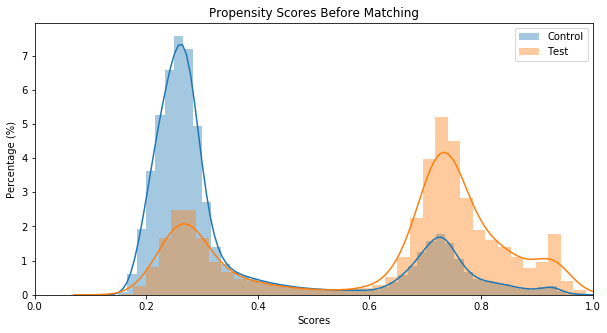

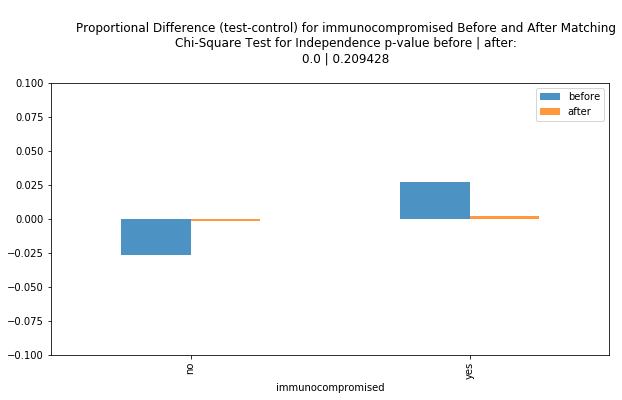

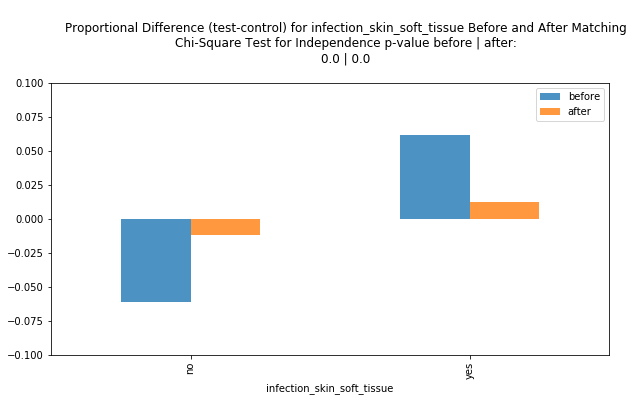

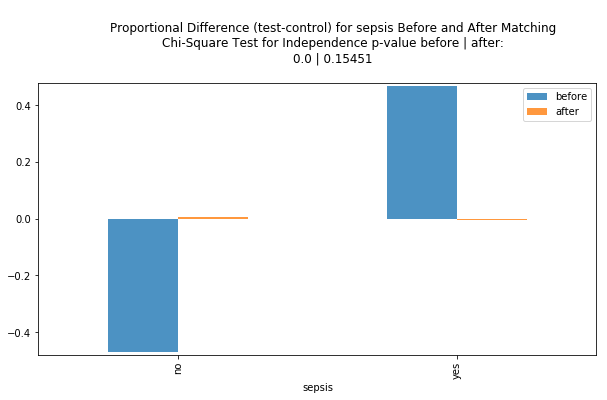

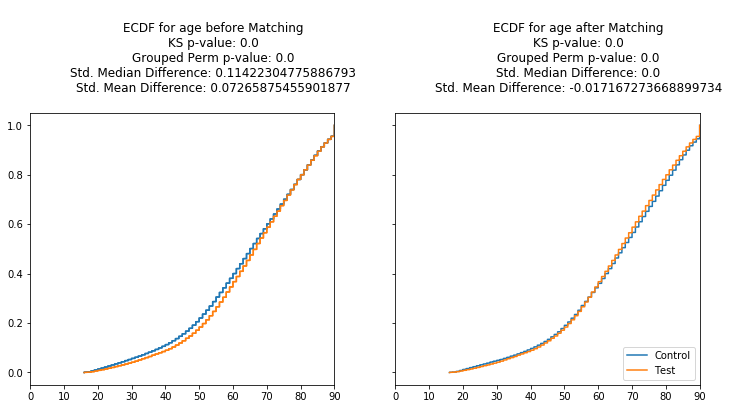

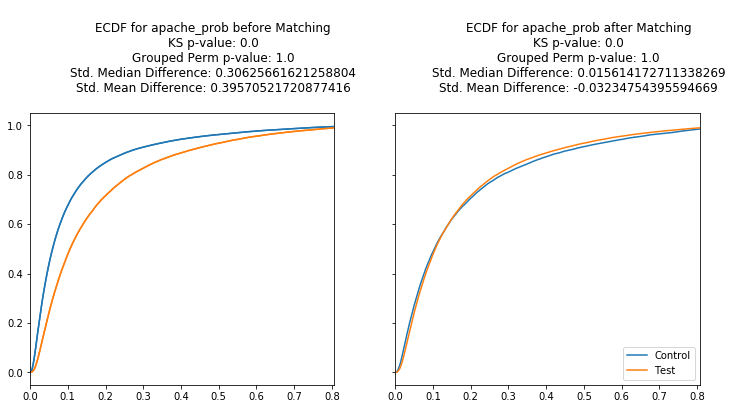

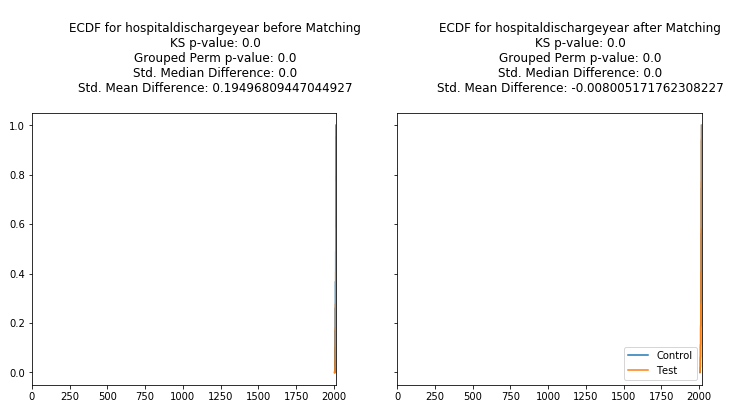

In [27]:
# add year
# INITIAL VANCO vs. NO VANCO
novanco = df[(df['vanco_wk'] == 0) & (df['vanco_adm'] == 0)].copy()
vanco = df[(df['vanco_adm'] == 1)].copy()
print(novanco.shape)
print(vanco.shape)
novanco = novanco.merge(yr, on='patientunitstayid')
vanco = vanco.merge(yr, on='patientunitstayid')
print(novanco.shape)
print(vanco.shape)

m_primary = calculate_or(exposure=vanco, control=novanco, seed=234,
                         cols=['age', 'apache_prob', 'sepsis',
                               'infection_skin_soft_tissue', 'immunocompromised',
                               'hospitaldischargeyear'])

No vanco: 309239 -> 223392 (delta: 85847)
Vanco: 59935 -> 48330 (delta: 11605)
Dataframe being used:


,age,apache_prob,sepsis,infection_skin_soft_tissue,immunocompromised
0,54.0,0.053958,no,no,no
1,37.0,0.013209,no,no,no
2,85.0,0.227421,yes,no,no
3,63.0,0.019505,no,no,no
4,79.0,0.033398,yes,no,no


Formula:
status ~ age+apache_prob+immunocompromised+infection_skin_soft_tissue+sepsis
n majority: 167454
n minority: 39433
Fitting Models on Balanced Samples: 100\100
Average Accuracy: 74.03%


,var,ks_before,ks_after,grouped_chisqr_before,grouped_chisqr_after,std_median_diff_before,std_median_diff_after,std_mean_diff_before,std_mean_diff_after
0,age,0.0,0.0,0.0,0.0,0.114771,0.000000,0.075495,0.016121
1,apache_prob,0.0,0.0,1.0,1.0,0.296470,-0.014066,0.384606,-0.041716


(39433, 57)

=== Odds ratio of exposure against aki ===

Diseased + Exposed: 13998
Healthy + Exposed: 25435
Diseased + Nonexposed: 13532
Healthy + Nonexposed: 25901
Odds Ratio: 1.053389026795421
95% CI: (1.022986583181096, 1.084695009706271)


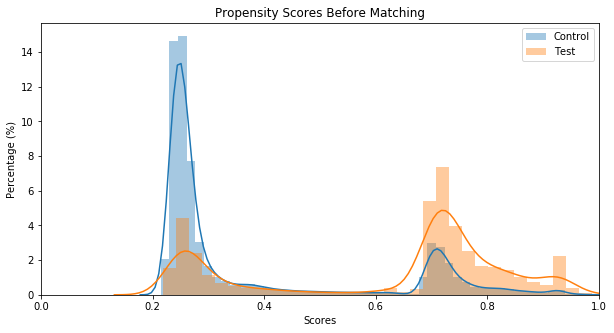

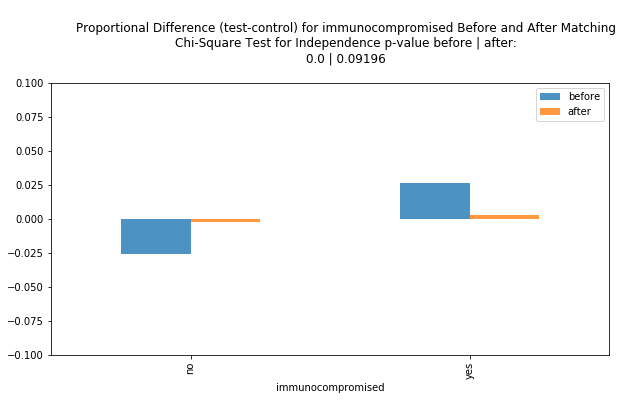

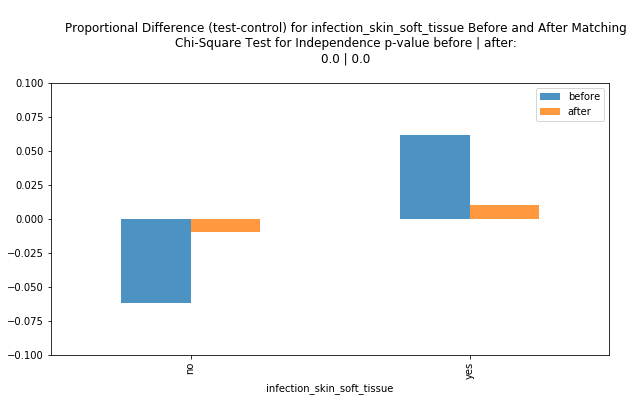

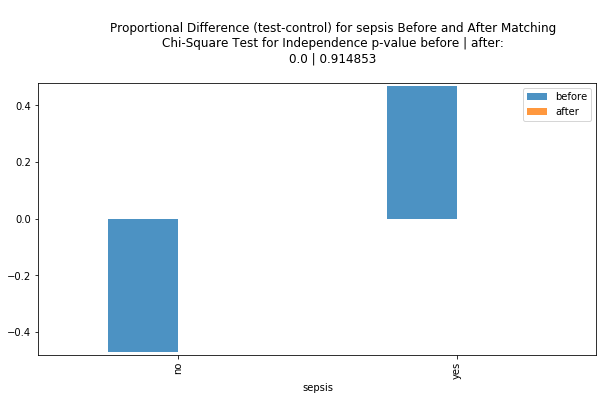

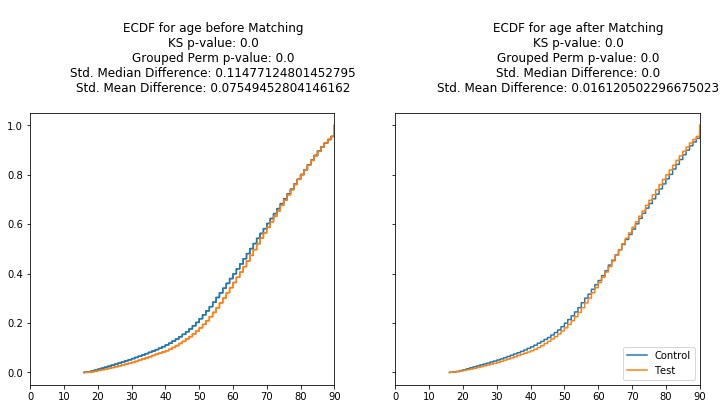

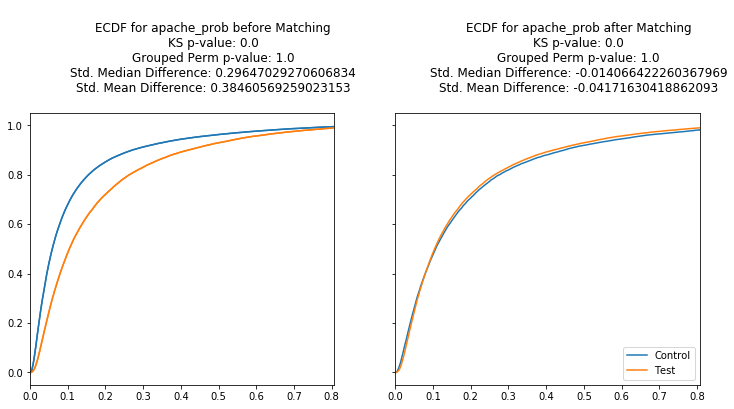

In [28]:
# exclude patients before 2010 and after 2015
novanco = df[(df['vanco_wk'] == 0) & (df['vanco_adm'] == 0)].copy()
vanco = df[(df['vanco_adm'] == 1)].copy()

n_no_vanco, n_vanco = novanco.shape[0], vanco.shape[0]
novanco = novanco.merge(yr, on='patientunitstayid')
vanco = vanco.merge(yr, on='patientunitstayid')

idx = (novanco['hospitaldischargeyear'] >= 2010) & (novanco['hospitaldischargeyear'] <= 2015)
novanco = novanco.loc[idx]
idx = (vanco['hospitaldischargeyear'] >= 2010) & (vanco['hospitaldischargeyear'] <= 2015)
vanco = vanco.loc[idx]

print('No vanco: {} -> {} (delta: {})'.format(n_no_vanco, novanco.shape[0], n_no_vanco - novanco.shape[0]))
print('Vanco: {} -> {} (delta: {})'.format(n_vanco, vanco.shape[0], n_vanco - vanco.shape[0]))

m_primary = calculate_or(exposure=vanco, control=novanco, seed=234,
                         cols=['age', 'apache_prob', 'sepsis',
                               'infection_skin_soft_tissue', 'immunocompromised'])